##### En este notebook  hago Análisis exploratorio de datos sobre el canje de un producto en particular y obtengo conclusiones al respecto

Nos centraremos en la campaña promocional de canje del almendrado realizada entre el 10/06 y el 19/06 por motivo del día del padre del 2022.

Dudas a resolver:
- Cuantos canjes se hicieron? --
- Cuantos socios canjearon? --
- Qué días se canjeó más? --
- Cuantas franquicias realizaron canjes? Cuanto sobre el total? --


- El canje fue acompañado de otros productos? --
- Comparación con canje de producto similar, con el total de canjes. --
- Cómo canjearon los segmentos?
- El canje fue acompañado de ventas?

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import pyodbc
import math
import os

import sidetable as stb
import glob

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)

In [2]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

SELECT e.ExchangeId, e.CustomerId, Convert(DATE, e.ExchangeDate) 'Fecha', e.Amount, e.ProductId, e.ProductName, e.BranchOfficeId
FROM dbo.Exchange e
WHERE e.ExchangeDate BETWEEN '2022-06-11' AND '2022-06-20'
"""
e = pd.read_sql(sql, conn)
e.head()

,ExchangeId,CustomerId,Fecha,Amount,ProductId,ProductName,BranchOfficeId
0,4542414,2F02F3CC-0222-C085-4246-08D51BC812DE,2022-06-11,1,56,Almendrado x8U.,0C5B1895-92EE-C4B8-2791-08D52AA72E37
1,4592409,6AB7E336-60E1-C824-CB13-08D432AC4B1B,2022-06-19,1,56,Almendrado x8U.,97238761-4EB7-CF0E-ACA4-08D1FFD89B51
2,4542850,A3C3ACF1-1607-C08D-472F-08D50A8F7E4C,2022-06-11,1,243,Yogurt Helado Frutilla Sin Tacc xU.,A60F83FF-0D43-C4EB-9E57-08D24690BE0B
3,4585536,2642926C-5694-CD40-8EF5-08D77C2CCB0E,2022-06-18,1,32,Grido Batido,D71DD0A3-47AD-C0B8-EFDB-08D2B20AF292
4,4543275,1BDEADC6-8537-C6AD-C40D-08D933508F63,2022-06-11,1,56,Almendrado x8U.,C5C5AFD8-9591-CBE2-BF78-08D2660B27B5


In [4]:
print('Socios que canjearon Almendrado:', e[e.ProductId == 56].CustomerId.nunique())
print('Cantidad de almendrados canjeados:', e[e.ProductId == 56].Amount.sum())
print('minima fecha:', e['Fecha'].min())
print('maxima fecha:', e['Fecha'].max())
print('Franquicias que canjearon Almendrado:', e[e.ProductId == 56].BranchOfficeId.nunique())
print('Participación de canjes Almendrado sobre el total de canjes durante la campaña:',
      round(e[(e.ProductId == 56)].ExchangeId.nunique()/e.ExchangeId.nunique()*100,1),'%')

Socios que canjearon Almendrado: 42119
Cantidad de almendrados canjeados: 42647
minima fecha: 2022-06-11
maxima fecha: 2022-06-19
Franquicias que canjearon Almendrado: 1546
Participación de canjes Almendrado sobre el total de canjes durante la campaña: 67.2 %


In [102]:
sns.set(rc={"axes.facecolor":"#E8E6E1","figure.facecolor":"#E8E6E1"})
sns.despine()

<Figure size 432x288 with 0 Axes>

### Evolucion de la campaña

Evolución en cantidad de canjes realizados

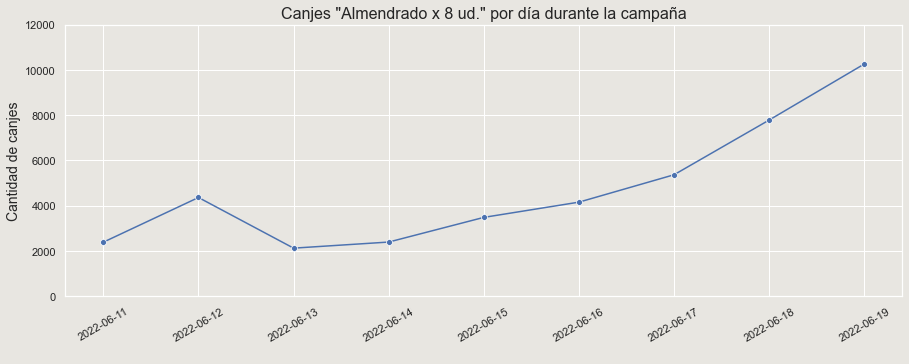

In [23]:
X= e[e.ProductId == 56].groupby("Fecha",as_index=False).ExchangeId.nunique()
X['dia'] = [i for i in range(1,10)]
fig, ax = plt.subplots(figsize=(15,5))
ax.tick_params(axis='x', labelrotation = 30)
ax.set_ylabel('Cantidad de canjes',fontsize=14)
ax.set_xlabel(' ')
ax.set_title('Canjes "Almendrado x 8 ud." por día durante la campaña',fontsize=16,loc='center')
plt.ylim(0,12000)
fig = sns.lineplot(data= X, x= "Fecha",y= "ExchangeId",marker='o')


Participación sobre el total de canjes

In [7]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

SELECT Convert(DATE, e.ExchangeDate) 'Fecha',COUNT(DISTINCT e.ExchangeId) 'canjes'
FROM dbo.Exchange e
WHERE e.ExchangeDate BETWEEN '2022-05-27' AND '2022-06-05'
AND e.ProductId = 56
GROUP BY Convert(DATE, e.ExchangeDate)
"""
e_anterior = pd.read_sql(sql, conn)
e_anterior.head()

,Fecha,canjes
0,2022-05-29,432
1,2022-06-01,116
2,2022-05-30,89
3,2022-06-03,156
4,2022-06-02,133


Extraigo canjes de un período anterior similar para hacer una comparacion

In [9]:
e_anterior.sort_values('Fecha',ascending=True,inplace=True)
e_anterior['dia'] = [i for i in range(1,10)]
e_anterior.head()

,Fecha,canjes,dia
6,2022-05-27,230,1
7,2022-05-28,375,2
0,2022-05-29,432,3
2,2022-05-30,89,4
8,2022-05-31,97,5


In [10]:
print('Cantidad de canjes en el período anterior:',e_anterior.canjes.sum())

Cantidad de canjes en el período anterior: 1936


Ahora, comparamos los 9 días de la campaña con 9 días anteriores que contemplan dos fines de semana al igual que la campaña.

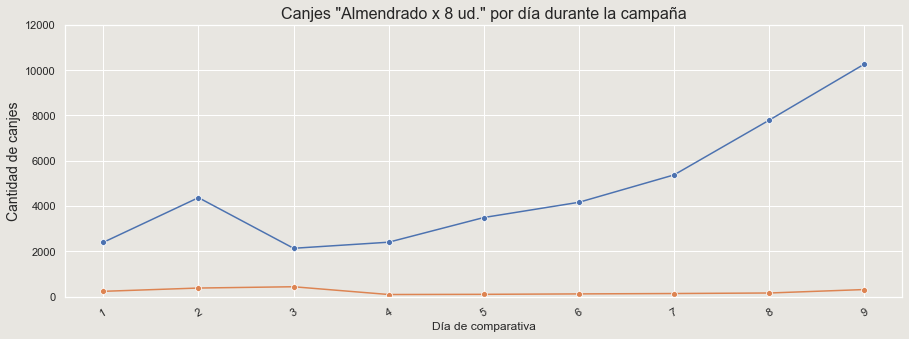

In [30]:
X['dia'] = [i for i in range(1,10)]
fig, ax = plt.subplots(figsize=(15,5))
ax.tick_params(axis='x', labelrotation = 30)
ax.set_ylabel('Cantidad de canjes',fontsize=14)
ax.set_xlabel('Día de comparativa')
ax.set_title('Canjes "Almendrado x 8 ud." por día durante la campaña',fontsize=16,loc='center')
plt.ylim(0,12000)
fig = sns.lineplot(x= X.dia,y= X.ExchangeId,marker='o')
fig = sns.lineplot(x= e_anterior.día, y= e_anterior.canjes,marker='o')



Penetracion de canjes del almendrado en el total de canjes

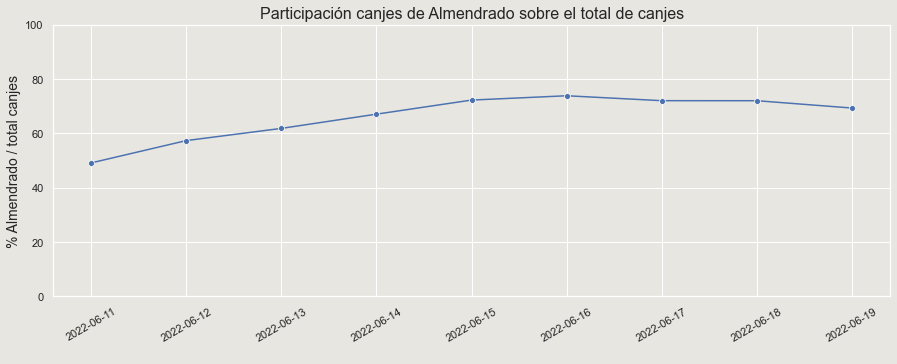

In [31]:
X['penetracion_unidades'] = X.ExchangeId / e.groupby("Fecha",as_index=False).ExchangeId.nunique()['ExchangeId'] * 100
fig, ax = plt.subplots(figsize=(15,5))
ax.tick_params(axis='x', labelrotation = 30)
ax.set_ylabel('% Almendrado / total canjes',fontsize=14)
ax.set_xlabel(' ')
ax.set_title('Participación canjes de Almendrado sobre el total de canjes',fontsize=16,loc='center')
plt.ylim(0,100)
fig = sns.lineplot(data= X, x= "Fecha",y= "penetracion_unidades",marker='o')

In [34]:
print('Penetración promedio del canje de almendrado:', round(X.penetracion_unidades.mean(),1),'%')

Penetración promedio del canje de almendrado: 66.1 %


### ¿Fueron canjes únicamente de Almendrado o estuvieron acompañados?

Agrupo por ExchangeId los canjes del período que hayan contenido al menos una caja de almendrado

In [40]:
X = e[e.ExchangeId.isin(e[(e.ProductId == 56)].ExchangeId)].groupby('ExchangeId',as_index=False).Amount.sum()
X.shape

(42354, 2)

In [41]:
print('Cantidad de canjes que incluyeron más de 1 producto:',X[X.Amount >1].shape[0],'. El ', round(X[X.Amount>1].shape[0]/X.shape[0]*100,1),'%')

Cantidad de canjes que incluyeron más de 1 producto: 4535 . El  10.7 %


Los productos más canjeados con el Almendrado fueron:

In [42]:
pd.DataFrame(e[e.ExchangeId.isin(e[(e.ProductId == 56)].ExchangeId) & (e.ProductId != 56)].ProductName.value_counts(normalize=True)*100).apply(lambda x: round(x,1)).reset_index().head(10)

,index,ProductName
0,Casatta x8U.,12.0
1,Bombon Escoces x8U.,10.3
2,Bombon Escoces xU.,7.2
3,Palito Frutal Frutilla xU.,5.9
4,Bombon Suizo x8U.,5.1
5,Bombon Crocante xU.,4.8
6,Palito Cremoso Americana xU.,4.8
7,Bombon Crocante x8U.,4.3
8,1/4 Kilo,4.1
9,Alfajor Shot x6U.,3.3


Cómo se comportaron los franquiciados?

Extraigo lista de los franquiciados que más canjes hicieron y los busco en el DW y Power BI

In [195]:
e[e.ProductId==56].groupby('BranchOfficeId',as_index=False).ExchangeId.count().sort_values('ExchangeId',ascending=False).head(15).BranchOfficeId.tolist()

['75032B8C-4EBB-CF8F-7F9B-08D2758F3B48',
 '79A0325A-3B39-CE92-3168-08D18A95FC6E',
 '80BB2015-6C7C-C10C-FB5A-08D286D57E09',
 'FD7C4A11-BFEE-C922-A8AB-08D2870A4128',
 '79CEA7F2-B7A6-CFF0-FB68-08D18A95C14A',
 '803F4BF2-EDA6-C55C-2AC3-08D2732CD20A',
 '5ECDAB6D-0ED5-CC8F-EBBF-08D1C57EE82A',
 '1FE00F01-A17F-CC52-143A-08D275967FCD',
 '40449ABD-4408-CE49-8BBE-08D28706A156',
 'BAAD3E15-E355-CA46-E5B7-08D1C5B8B108',
 'F26F6A68-1F53-CA5D-EA22-08D422C96057',
 'E92BFD98-D005-C1DF-DBD6-08D0BA8A8368',
 'A9686735-6BE2-C998-8761-08D2AFB42D7C',
 'C5A6EC51-3750-CE23-C9A7-08D2AFDD007D',
 'D8BA51AF-132B-C2E1-B452-08D2AFDF9F2E']

#### Importo Datos de clientes

In [11]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """
SELECT
c.CustomerId, CONVERT(DATE,c.ActivatedDate) 'fecha_asociacion', c.Email,
count(DISTINCT case when e.ExchangeDate < '2022-06-11' then e.exchangeId else null end) 'cantidad_canjes',
CONVERT(DATE,max(case when s.SaleDate < '2022-06-11' then s.SaleDate end)) 'ultima_compra',
CONVERT(DATE,max(case when e.ExchangeDate < '2022-06-11' then e.ExchangeDate end)) 'ultimo_canje'
, seg.categoria
FROM dbo.Customer c
LEFT JOIN dbo.Exchange e ON c.CustomerId = e.CustomerId
LEFT JOIN dbo.SaleCustomer sc ON sc.CustomerId=c.CustomerId
LEFT JOIN dbo.Sale s ON s.SaleId = sc.SaleId
LEFT JOIN dbo.Clientes_segmentacion_2022 seg ON seg.CustomerId = c.CustomerId

WHERE c.CustomerId IN (SELECT e.CustomerId 
                        FROM dbo.Exchange e 
                        WHERE e.ProductId = 56 
                        AND e.ExchangeDate BETWEEN '2022-06-11' AND '2022-06-20'
                        GROUP BY e.CustomerId) 
GROUP BY c.CustomerId, c.ActivatedDate, c.Email, seg.categoria
"""
clientes = pd.read_sql(sql, conn)
clientes.head()

,CustomerId,fecha_asociacion,Email,cantidad_canjes,ultima_compra,ultimo_canje,categoria
0,1D98B7F7-F833-C02E-DAA6-08D1435402FA,2014-01-08,pamela_administracion@hotmail.com,17,2022-06-04,2022-05-29,ALERTA DE CONSUMO
1,1DA46825-B486-C6AF-98A0-08D0DC4B02B4,2014-01-06,cristinalope_23@hotmail.com,7,2022-04-01,2021-11-23,ORO
2,8EA23418-9D5A-CEB4-353C-08D0E2DCF98C,2013-12-20,nomail@none.com,3,2020-08-17,2019-10-20,ABANDONO
3,4FC72B29-6F51-C1C2-F85E-08D0E1128FC2,2014-01-10,matingm01@gmail.com,2,2022-05-10,2021-02-22,PLATA
4,ECA8E3D8-A621-C7AF-D712-08D0E06C0EA0,2013-12-16,paulamaggi@hotmail.com.ar,3,2022-04-16,2022-02-04,ORO


#### - Cuantos socios canjearon por primera vez?

In [12]:
clientes['ultima_compra']= pd.to_datetime(clientes['ultima_compra'])
clientes['ultimo_canje']= pd.to_datetime(clientes['ultimo_canje'])
clientes['ultima_actividad']= clientes[['ultimo_canje','ultima_compra']].max(axis=1)

In [13]:
print('Cantidad de clientes que canjearon por primera vez:',clientes[clientes.cantidad_canjes == 0].shape[0],\
      'que significa el',round(clientes[clientes.cantidad_canjes == 0].shape[0]/clientes.shape[0]*100,1),'% de los socios que canjearon Almendrado')

print('Cantidad de clientes que canjearon por segunda vez:',clientes[clientes.cantidad_canjes == 1].shape[0],\
      'que significa el',round(clientes[clientes.cantidad_canjes == 1].shape[0]/clientes.shape[0]*100,1),'% de los socios que canjearon Almendrado')

Cantidad de clientes que canjearon por primera vez: 9997 que significa el 23.7 % de los socios que canjearon Almendrado
Cantidad de clientes que canjearon por segunda vez: 8303 que significa el 19.7 % de los socios que canjearon Almendrado


#### - Se asociaron recientemente?

In [18]:
fecha_canje = e[e.ProductId == 56].groupby('CustomerId',as_index=False).Fecha.min()
fecha_canje.columns=['CustomerId','fecha_canje_almendrado']

#clientes = clientes.merge(fecha_canje, on='CustomerId',how='left')

clientes['dias_entre_asociacion_y_canje'] = (pd.to_datetime(clientes.fecha_canje_almendrado) - pd.to_datetime(clientes.fecha_asociacion)) / np.timedelta64(1,'D')
clientes['dias_entre_asociacion_y_canje'] = clientes['dias_entre_asociacion_y_canje'].apply(np.floor).astype('int')

print('Tenemos', clientes[clientes.dias_entre_asociacion_y_canje == 0].shape[0],'socios que se dieron de alta el mismo día del canje')

Tenemos 0 socios que se dieron de alta el mismo día del canje


In [60]:
print('Los socios que canjearon por primera vez, habian pasado aproximadamente', clientes[clientes.cantidad_canjes == 0].dias_entre_asociacio_y_canje.median(),'días activos previamente')

Los socios que canjearon por primera vez, habian pasado aproximadamente 1145.0 días activos previamente


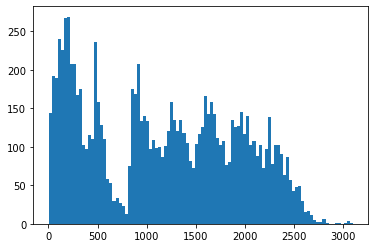

In [20]:
plt.hist(clientes[clientes.cantidad_canjes == 0].dias_entre_asociacion_y_canje,bins=100)
plt.show()

#### Analizo compras y canjes durante este tiempo

Cuantos canjes fueron acompañados de una compra?

In [21]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """
SELECT
sc.CustomerId, s.SaleId, convert(date,s.SaleDate) 'SaleDate', s.ProductId, s.ProductName, s.Amount, s.ProductWeightGrams,s.BranchOfficeId
FROM dbo.SaleCustomer sc
INNER JOIN dbo.Sale s ON s.SaleId = sc.SaleId
WHERE s.SaleDate BETWEEN '2022-06-11' AND '2022-06-20'

"""
sale = pd.read_sql(sql, conn)
sale.head()

,CustomerId,SaleId,SaleDate,ProductId,ProductName,Amount,ProductWeightGrams,BranchOfficeId
0,A0A0403F-B9C1-CB22-7013-08D2F1F79C18,128448471,2022-06-12,54.0,Palito Frutal Limon x20U.,2,1100.0,221661E2-6F69-CE94-0EA4-08D2863E51B5
1,9A23D896-F2CD-CCE0-709A-08D797BB73EE,128448512,2022-06-12,64.0,1 Kilo,1,1000.0,5983C654-9E53-CFE8-DA95-08D6F0170446
2,D628D9AA-0FC6-CF0E-C3F1-08DA1697ADAC,128448405,2022-06-12,70.0,Gigante 3 Bochas,2,240.0,5394FBB9-0550-CBE1-55EA-08D574723CA1
3,6C0EE8A5-39EE-CF63-D9C7-08D98901ACF9,128448433,2022-06-12,192.0,Pizza Moz. y Jamon Frizzio,2,734.0,FE895D04-08ED-CE77-7C8B-08D8871F6D80
4,564258B1-B1AA-C0D2-0CE2-08D8B7B02984,128448726,2022-06-12,3.0,Bombon Escoces x8U.,1,720.0,D2DD5058-9E6D-C441-7684-08D2710A29E9


In [23]:
sale['kilos'] = sale.Amount * sale.ProductWeightGrams * 0.001

Agrupo ventas buscando obtener su SaleId, CustomerId y fecha. Con estos datos despues lo cruzo con los canjes para ver si hubo compra y canje al mismo momento.

In [29]:
sale_agrupada = sale.groupby(['SaleId','CustomerId','BranchOfficeId'],as_index=False).agg({'SaleDate':'min','kilos':'sum'})
sale_agrupada.sort_values('kilos',ascending=False,inplace=True)
sale_agrupada.drop_duplicates(subset=['CustomerId','SaleDate','BranchOfficeId'],inplace=True)
sale_agrupada.head()

,SaleId,CustomerId,BranchOfficeId,SaleDate,kilos
158206,128531023,FA47AEF9-E54F-C79C-BCCC-08D77613495E,6B2CAAE3-A993-CC17-A482-08D22035431B,2022-06-14,84.000
67766,128435369,27B13314-0B83-CA60-A74B-08D40FFCF51F,CA9F8758-45EB-CADE-D0E3-08D2B2099B85,2022-06-12,72.496
340744,128724225,31D3E74A-1780-C394-07A6-08D4C72FC358,CA9F8758-45EB-CADE-D0E3-08D2B2099B85,2022-06-18,71.680
323422,128705969,F9F70F98-3DDE-CA23-737D-08D43A4F4A56,36D7BB1A-AFCA-C36E-BC13-08D2AFB27431,2022-06-18,70.880
154352,128526972,82E0732F-A82B-CC41-6359-08D4D62BFD1B,36D7BB1A-AFCA-C36E-BC13-08D2AFB27431,2022-06-14,70.700


Agrupo los canjes de almendrado para obtener también customerId, fecha y BO Id

In [30]:
e_56 = e[e.ProductId==56].groupby(['ExchangeId','CustomerId','BranchOfficeId'],as_index=False).Fecha.min()
e_56.head()

,ExchangeId,CustomerId,BranchOfficeId,Fecha
0,4541637,63DD8BA4-092C-C848-E318-08D8D999E5FA,4DC467DA-C6E9-C5AB-DA4A-08D1BCEEC44B,2022-06-11
1,4541640,9E9EC571-159D-C52F-B8B9-08D5DDDD3BE6,E31E8A39-B114-C1BE-81CB-08D18A9560A4,2022-06-11
2,4541658,7E31D1C2-426E-C80F-7917-08DA4B3DAAF8,93F61B44-50A3-C8C9-63CF-08D60F3FDA87,2022-06-11
3,4541659,CE796E74-57C7-CF58-FD45-08D51C5D166E,4C46A5EE-7B39-C2E8-929D-08D24993A60C,2022-06-11
4,4541665,ED90A1D3-3958-CEF3-BA59-08D31709FDBA,311B33AD-373F-C5DE-E73B-08D286D8D1F6,2022-06-11


In [31]:
e_56.shape

(42354, 4)

In [32]:
e_56 = e_56.merge(sale_agrupada,how='left',left_on=['CustomerId','Fecha','BranchOfficeId'],right_on=['CustomerId','SaleDate','BranchOfficeId'])
e_56.shape

(42354, 7)

In [33]:
e_56.isnull().sum()

ExchangeId            0
CustomerId            0
BranchOfficeId        0
Fecha                 0
SaleId            24575
SaleDate          24575
kilos             24575
dtype: int64

In [34]:
fqcia_venta_canje= e_56.groupby('BranchOfficeId',as_index=False).agg({'ExchangeId':'count','SaleId':'count','kilos':'sum'})
fqcia_venta_canje['%canjes_acompañados']= round(fqcia_venta_canje.SaleId / fqcia_venta_canje.ExchangeId * 100,1)
fqcia_venta_canje[fqcia_venta_canje.ExchangeId > 80].sort_values('%canjes_acompañados',ascending = False).head(10)

,BranchOfficeId,ExchangeId,SaleId,kilos,%canjes_acompañados
1035,A9686735-6BE2-C998-8761-08D2AFB42D7C,94,65,56.769,69.1
1036,A98BE6A2-BCD7-C9D1-A933-08D28637FDCD,90,59,67.882,65.6
1161,BD5F7034-18F2-C332-2193-08D18A93D8DD,81,53,61.363,65.4
85,0CDD1FA3-4698-CEDD-2A53-08D49DFFC0C0,83,51,52.711,61.4
204,1FE00F01-A17F-CC52-143A-08D275967FCD,99,60,77.203,60.6
578,5ECDAB6D-0ED5-CC8F-EBBF-08D1C57EE82A,105,60,63.386,57.1
205,1FFF46A0-7414-C402-1D65-08D286DA51C8,81,45,48.340,55.6
798,80BB2015-6C7C-C10C-FB5A-08D286D57E09,109,60,81.402,55.0
1391,E92BFD98-D005-C1DF-DBD6-08D0BA8A8368,94,51,48.407,54.3
748,7A6B9407-24AC-C32F-36F3-08D275890A08,83,44,42.936,53.0


In [35]:
print('El promedio de canjes acompañados por una venta fue:',fqcia_venta_canje['%canjes_acompañados'].mean())

El promedio de canjes acompañados por una venta fue: 39.9560155239328


In [36]:
sale_acompañaron = sale[sale.SaleId.isin(e_56.SaleId)]
sale_acompañaron.shape

(27975, 9)

In [38]:
print('En total,',e_56[~e_56.SaleId.isnull()].ExchangeId.nunique(),'canjes fueron acompañados por una compra que representó el',\
     round(e_56[~e_56.SaleId.isnull()].ExchangeId.nunique()/e_56.ExchangeId.nunique()*100,1),'%')

En total, 17779 canjes fueron acompañados por una compra que representó el 42.0 %


In [40]:
print('Un total de', sale_acompañaron.kilos.sum(),'kilos vendidos acompañaron los canjes de almendrado')

Un total de 18668.359 kilos vendidos acompañaron los canjes de almendrado


Productos más vendidos acompañando el canje

In [41]:
sale_acompañaron.groupby('ProductName',as_index=False).kilos.sum().sort_values('kilos',ascending=False).head(5)

,ProductName,kilos
0,1 Kilo,3232.00
135,Bombon Escoces x8U.,1195.92
188,Familiar Nº 2 (Americana/Frutilla/Ddl Graniz.),790.40
324,Torta Oreo,746.13
3,1/2 Kilo,744.00


In [42]:
productos_mas_vendidos = sale_acompañaron.groupby('ProductName',as_index=False).Amount.sum().sort_values('Amount',ascending=False)
productos_mas_vendidos['%venta'] = productos_mas_vendidos.Amount / productos_mas_vendidos.Amount.sum()*100
productos_mas_vendidos.head()

,ProductName,Amount,%venta
0,1 Kilo,3232,9.601616
135,Bombon Escoces x8U.,1661,4.934494
5,1/4 Kilo,1568,4.658210
123,Alfajor Shot x6U.,1507,4.476991
3,1/2 Kilo,1488,4.420546


In [43]:
sale_acompañaron.groupby('BranchOfficeId',as_index=False).kilos.sum().sort_values('kilos',ascending=False).head(10)

,BranchOfficeId,kilos
1186,CA9F8758-45EB-CADE-D0E3-08D2B2099B85,87.463
771,80BB2015-6C7C-C10C-FB5A-08D286D57E09,81.402
196,1FE00F01-A17F-CC52-143A-08D275967FCD,77.203
999,A98BE6A2-BCD7-C9D1-A933-08D28637FDCD,67.882
938,9D20A4CB-16BE-CADA-F506-08D5DAA2A189,64.977
558,5ECDAB6D-0ED5-CC8F-EBBF-08D1C57EE82A,63.386
374,40449ABD-4408-CE49-8BBE-08D28706A156,63.186
1119,BD5F7034-18F2-C332-2193-08D18A93D8DD,61.363
270,2D13CA73-883C-CF25-D49A-08D4E63523A1,59.887
1031,AE963D04-A481-CFB4-29C3-08D18AA29B71,59.876


In [44]:
sale_acompañaron.groupby('BranchOfficeId',as_index=False).kilos.sum().sort_values('kilos',ascending=False).head(10)

,BranchOfficeId,kilos
1186,CA9F8758-45EB-CADE-D0E3-08D2B2099B85,87.463
771,80BB2015-6C7C-C10C-FB5A-08D286D57E09,81.402
196,1FE00F01-A17F-CC52-143A-08D275967FCD,77.203
999,A98BE6A2-BCD7-C9D1-A933-08D28637FDCD,67.882
938,9D20A4CB-16BE-CADA-F506-08D5DAA2A189,64.977
558,5ECDAB6D-0ED5-CC8F-EBBF-08D1C57EE82A,63.386
374,40449ABD-4408-CE49-8BBE-08D28706A156,63.186
1119,BD5F7034-18F2-C332-2193-08D18A93D8DD,61.363
270,2D13CA73-883C-CF25-D49A-08D4E63523A1,59.887
1031,AE963D04-A481-CFB4-29C3-08D18AA29B71,59.876


#### Cuanto tiempo pasaron sin comprar hasta que fueron a la heladeria de nuevo?

In [45]:
clientes = clientes.merge(sale_acompañaron.groupby('CustomerId',as_index=False).SaleDate.min(),on='CustomerId',how='left')
clientes.shape

(42118, 11)

In [46]:
clientes.isnull().sum()

CustomerId                           0
fecha_asociacion                     0
Email                                0
cantidad_canjes                      0
ultima_compra                      220
ultimo_canje                      9997
categoria                            1
ultima_actividad                   194
fecha_canje_almendrado               0
dias_entre_asociacion_y_canje        0
SaleDate                         24406
dtype: int64

In [47]:
clientes.ultima_actividad.fillna('2000-01-01',inplace=True)
clientes.ultima_compra.fillna('2000-01-01',inplace=True)
clientes['dias_sin_compra'] = (pd.to_datetime(clientes.fecha_canje_almendrado) - pd.to_datetime(clientes.ultima_compra)) / np.timedelta64(1,'D')
clientes['dias_sin_compra'] = clientes['dias_sin_compra'].apply(np.floor).astype('int')

,CustomerId,fecha_asociacion,Email,cantidad_canjes,ultima_compra,ultimo_canje,categoria,ultima_actividad,fecha_canje_almendrado,dias_entre_asociacion_y_canje,SaleDate,dias_sin_compra
0,1D98B7F7-F833-C02E-DAA6-08D1435402FA,2014-01-08,pamela_administracion@hotmail.com,17,2022-06-04,2022-05-29,ALERTA DE CONSUMO,2022-06-04,2022-06-18,3083,2022-06-18,14
1,1DA46825-B486-C6AF-98A0-08D0DC4B02B4,2014-01-06,cristinalope_23@hotmail.com,7,2022-04-01,2021-11-23,ORO,2022-04-01,2022-06-14,3081,2022-06-14,74
2,8EA23418-9D5A-CEB4-353C-08D0E2DCF98C,2013-12-20,nomail@none.com,3,2020-08-17,2019-10-20,ABANDONO,2020-08-17,2022-06-17,3101,NaN,669
3,4FC72B29-6F51-C1C2-F85E-08D0E1128FC2,2014-01-10,matingm01@gmail.com,2,2022-05-10,2021-02-22,PLATA,2022-05-10,2022-06-18,3081,NaN,39
4,ECA8E3D8-A621-C7AF-D712-08D0E06C0EA0,2013-12-16,paulamaggi@hotmail.com.ar,3,2022-04-16,2022-02-04,ORO,2022-04-16,2022-06-12,3100,NaN,57


In [48]:
clientes['dias_sin_actividad'] = (pd.to_datetime(clientes.fecha_canje_almendrado) - pd.to_datetime(clientes.ultima_actividad)) / np.timedelta64(1,'D')
clientes['dias_sin_actividad'] = clientes['dias_sin_actividad'].apply(np.floor).astype('int')

In [49]:
clientes.dias_sin_compra.median()

33.0

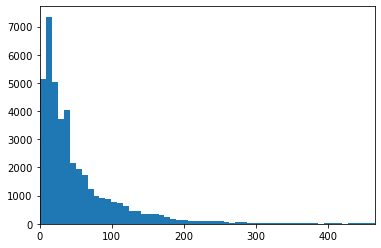

In [50]:
plt.xlim(0,465)
plt.hist(clientes.dias_sin_compra,bins=1000)
plt.show()

In [51]:
clientes.dias_sin_compra.mode()

0    14
dtype: int32

In [57]:
clusters = [-np.inf,30,60,90,120,180,365,np.inf]
nombres_clusters = ['Menos de 1 mes','Entre 1 y 2 meses','Entre 2 y 3 meses','Entre 3 y 4 meses','Entre 4 y 6 meses','Entre 6 y 12 meses','Más de 12 meses']
clientes['segmento_última_compra'] = pd.cut(clientes.dias_sin_compra,bins= clusters, labels = nombres_clusters)
clientes['segmento_última_actividad'] = pd.cut(clientes.dias_sin_actividad,bins= clusters, labels = nombres_clusters)

In [58]:
clientes.stb.freq(['segmento_última_compra'])

,segmento_última_compra,count,percent,cumulative_count,cumulative_percent
0,Menos de 1 mes,20436,48.520822,20436,48.520822
1,Entre 1 y 2 meses,9287,22.049955,29723,70.570777
2,Entre 2 y 3 meses,4372,10.380360,34095,80.951137
3,Entre 3 y 4 meses,2924,6.942400,37019,87.893537
4,Entre 4 y 6 meses,2788,6.619498,39807,94.513035
5,Entre 6 y 12 meses,1520,3.608908,41327,98.121943
6,Más de 12 meses,791,1.878057,42118,100.000000


In [59]:
clientes.stb.freq(['segmento_última_actividad'])

,segmento_última_actividad,count,percent,cumulative_count,cumulative_percent
0,Menos de 1 mes,20704,49.157130,20704,49.157130
1,Entre 1 y 2 meses,9587,22.762239,30291,71.919369
2,Entre 2 y 3 meses,4276,10.152429,34567,82.071798
3,Entre 3 y 4 meses,2792,6.628995,37359,88.700793
4,Entre 4 y 6 meses,2639,6.265730,39998,94.966523
5,Entre 6 y 12 meses,1412,3.352486,41410,98.319008
6,Más de 12 meses,708,1.680992,42118,100.000000


### Socios que abrieron el mail y canjearon?

In [93]:
path = r''
all_files = glob.glob(path + "\*.csv")

envios_efectivos = pd.concat((pd.read_csv(f,delimiter = ";",encoding='utf16') for f in all_files))
envios_efectivos.sort_values('FECHA',inplace=True)
envios_efectivos.shape

(349214, 5)

In [94]:
envios_efectivos.drop_duplicates(subset=['EMAIL'],inplace=True)
print(envios_efectivos.shape[0],'personas abrieron al menos un mail')

251240 personas abrieron al menos un mail


In [68]:
clientes['abrieron_mail'] = np.where(clientes.Email.isin(envios_efectivos.EMAIL),1,0)
clientes.abrieron_mail.value_counts(normalize=True)

0    0.553208
1    0.446792
Name: abrieron_mail, dtype: float64

In [71]:
clientes['canjearon_y_compraron']=np.where(~clientes.SaleDate.isnull(),1,0)

In [72]:
clientes.canjearon_y_compraron.value_counts(normalize=True)

0    0.579467
1    0.420533
Name: canjearon_y_compraron, dtype: float64

In [74]:
print( 'Socios que abrieron el mail, canjearon y compraron:', clientes[(clientes.canjearon_y_compraron ==1) & (clientes.abrieron_mail == 1)].shape[0])
print('Sobre el total que canjearon y compraron esto es',clientes[(clientes.canjearon_y_compraron ==1) & (clientes.abrieron_mail == 1)].shape[0]/clientes[clientes.canjearon_y_compraron ==1].shape[0]*100)
print('Sobre el total que canjearon',clientes[(clientes.canjearon_y_compraron ==1) & (clientes.abrieron_mail == 1)].shape[0]/clientes.shape[0]*100)

Socios que abrieron el mail, canjearon y compraron: 6181
Sobre el total que canjearon y compraron esto es 34.89724480578139
Sobre el total que canjearon 14.675435680706586


¿Cuanto tiempo tardan en comprar los socios luego de abrir el mail?

In [76]:
clientes.head()

,CustomerId,fecha_asociacion,Email,cantidad_canjes,ultima_compra,ultimo_canje,categoria,ultima_actividad,fecha_canje_almendrado,dias_entre_asociacion_y_canje,SaleDate,dias_sin_compra,dias_sin_actividad,segmento_última_compra,segmento_última_actividad,abrieron_mail,canjearon_y_compraron
0,1D98B7F7-F833-C02E-DAA6-08D1435402FA,2014-01-08,pamela_administracion@hotmail.com,17,2022-06-04,2022-05-29,ALERTA DE CONSUMO,2022-06-04,2022-06-18,3083,2022-06-18,14,14,Menos de 1 mes,Menos de 1 mes,0,1
1,1DA46825-B486-C6AF-98A0-08D0DC4B02B4,2014-01-06,cristinalope_23@hotmail.com,7,2022-04-01,2021-11-23,ORO,2022-04-01,2022-06-14,3081,2022-06-14,74,74,Entre 2 y 3 meses,Entre 2 y 3 meses,0,1
2,8EA23418-9D5A-CEB4-353C-08D0E2DCF98C,2013-12-20,nomail@none.com,3,2020-08-17,2019-10-20,ABANDONO,2020-08-17,2022-06-17,3101,NaN,669,669,Más de 12 meses,Más de 12 meses,0,0
3,4FC72B29-6F51-C1C2-F85E-08D0E1128FC2,2014-01-10,matingm01@gmail.com,2,2022-05-10,2021-02-22,PLATA,2022-05-10,2022-06-18,3081,NaN,39,39,Entre 1 y 2 meses,Entre 1 y 2 meses,0,0
4,ECA8E3D8-A621-C7AF-D712-08D0E06C0EA0,2013-12-16,paulamaggi@hotmail.com.ar,3,2022-04-16,2022-02-04,ORO,2022-04-16,2022-06-12,3100,NaN,57,57,Entre 1 y 2 meses,Entre 1 y 2 meses,0,0


In [75]:
envios_efectivos.head()

,FECHA,EMAIL,ACTIVIDAD,CAMPANIA,ACCION
13854,2022-06-24 10:54:12.500,rominagiselediaz89@gmail.com,Aperturas Originales,JUNIO 22,Día del padre - A ACTIVAR
4728,2022-06-24 10:53:39.647,ernecur1959@gmail.com,Aperturas Originales,JUNIO 22,Día del padre - A ACTIVAR
2091,2022-06-24 10:53:38.290,caiacabj16@gmail.com,Aperturas Originales,JUNIO 22,Día del padre - A ACTIVAR
8285,2022-06-24 10:53:28.940,lananudesanmiguel@gmail.com,Aperturas Originales,JUNIO 22,Día del padre - A ACTIVAR
16617,2022-06-24 10:52:39.957,zulmavitale.67@gmail.com,Aperturas Originales,JUNIO 22,Día del padre - A ACTIVAR


In [96]:
clientes.drop(columns=['fecha_apertura_mail'],inplace=True)

In [97]:
clientes=clientes.merge(envios_efectivos[['FECHA','EMAIL']],left_on='Email',right_on='EMAIL',how='left')
clientes.drop(columns=['EMAIL'],inplace=True)
clientes.rename(columns={'FECHA':'fecha_apertura_mail'},inplace=True)
clientes['fecha_apertura_mail'] = pd.to_datetime(clientes['fecha_apertura_mail']).dt.date
clientes['dias_entre_apertura_mail_y_canje'] = (pd.to_datetime(clientes.fecha_canje_almendrado) - pd.to_datetime(clientes.fecha_apertura_mail)) / np.timedelta64(1,'D')

In [104]:
clientes.stb.freq(['dias_entre_apertura_mail_y_canje'])

,dias_entre_apertura_mail_y_canje,count,percent,cumulative_count,cumulative_percent
0,0.0,3453,18.349453,3453,18.349453
1,1.0,2988,15.878414,6441,34.227867
2,3.0,2027,10.771602,8468,44.999469
3,2.0,1968,10.458072,10436,55.457541
4,4.0,1795,9.538740,12231,64.996280
5,7.0,1397,7.423743,13628,72.420023
6,6.0,1343,7.136784,14971,79.556807
7,8.0,1220,6.483154,16191,86.039962
8,5.0,1202,6.387501,17393,92.427463
9,-1.0,346,1.838665,17739,94.266128


##### Extraigo el listado de socios para, en un futuro, hacer un analisis sobre cambio de comportamiento de consumo a partir de esta accion

In [285]:
clientes[['CustomerId','canjearon_y_compraron', 'dias_entre_asociacio_y_canje','dias_sin_compra',
       'dias_sin_actividad', 'segmento_última_compra',
       'segmento_última_actividad']].to_excel(r'')